<a href="https://colab.research.google.com/github/raghuvansh-sahil/DSc-Project-23ucs694/blob/main/DScProject_23ucs694.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective of this project is to analyze whether **daily news sentiment**, derived from Nvidia-related headlines, has any noticeable effect on the company’s **stock price**. By combining structured text data (news) with structured financial data (stock prices), we aim to uncover correlations that might hint at a relationship between what’s in the headlines and what’s happening in the markets.

In [ ]:
# To fetch daily stock price data directly from Yahoo Finance
!pip install yfinance

In [ ]:
# To interact with NewsAPI and fetch real-time or historical news headlines
!pip install requests

In [ ]:
# To tokenize, clean, and manipulate textual data before analysis
!pip install nltk

In [ ]:
# A sentiment analysis tool specifically tuned to social and news media language
!pip install vaderSentiment

For this project, we will use two primary datasets:

- **Stock Prices from Yahoo Finance** — Using the `yfinance` library, we will obtain daily **closing prices** for Nvidia within our time range.
- **News Headlines from NewsAPI** — We will use the keyword “Nvidia” to extract English-language headlines related to Nvidia.

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

start_date = "2025-01-01"
end_date = datetime.now().strftime("%Y-%m-%d") # This will give us the present date

# Using the yfinance library, we will obtain daily closing prices for Nvidia within our time range
nvidia_stock = yf.Ticker("NVDA")
stock_data = nvidia_stock.history(start=start_date, end=end_date)
stock_data.reset_index(inplace=True)
stock_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-01-02 00:00:00-05:00,135.987487,138.867227,134.617618,138.297272,198247200,0.0,0.0
1,2025-01-03 00:00:00-05:00,139.997114,144.886664,139.717141,144.456711,229322500,0.0,0.0
2,2025-01-06 00:00:00-05:00,148.576325,152.146004,147.806407,149.416245,265377400,0.0,0.0
3,2025-01-07 00:00:00-05:00,153.015919,153.115916,139.997113,140.127106,351782200,0.0,0.0
4,2025-01-08 00:00:00-05:00,142.566896,143.936766,137.547354,140.097122,227349900,0.0,0.0


In [ ]:
import requests

api_key = 'cac6dbe6b65343e2bbc0447449fd0be8'

url = 'https://newsapi.org/v2/everything'
params = {
    'q': 'Nvidia', # We will use the keyword “Nvidia” to extract headlines related to Nvidia
    'from': (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d'), # We will fetch news headlines in the past month
    'sortBy': 'relevancy',
    'apiKey': api_key,
    'pageSize': 100,
    'language': 'en' # We will extract English-language headlines
}

response = requests.get(url, params=params) # Sending a request and getting a response
data = response.json()

if data['status'] != 'ok':
  raise Exception(f"NewsAPI Error: {data['message']}")

articles = data['articles']

news_data = pd.DataFrame(articles)
news_data = news_data[['publishedAt', 'title']]
news_data.columns = ['date', 'headline']
news_data.head()

,date,headline
0,2025-04-30T13:19:12Z,Nvidia’s new tool can turn 3D scenes into AI i...
1,2025-04-15T13:02:36Z,Nvidia’s RTX 5060 Ti arrives on April 16th sta...
2,2025-04-15T14:30:19Z,Nvidia Promises the RTX 5060 Ti Is a 1440p Bea...
3,2025-04-14T15:37:19Z,Nvidia leans further into US manufacturing as ...
4,2025-05-02T10:00:00Z,The Climate Crisis Threatens Supply Chains. Ma...


To ensure the text data was useful for sentiment analysis, we performed the following cleaning steps:

- **Only Alphabets in the Headlines** — Numbers, punctuation, and special characters will not contribute much in sentiment analysis.
- **Removal of Stop Words from the Headlines** — Stopwords are the common words like "the", "is", "and" and many more, that add little meaning. Therefore, we have to erase these words from our headlines.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab') # This downloads a pretrained tokenizer that helps split text into sentences or words
nltk.download('stopwords') # This downloads the list of stopwords in various languages.
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
  words = word_tokenize(text)
  words = [word for word in words if word.isalpha()] # Filtering out the non-alphabet characters
  words = [word for word in words if word.lower() not in stop_words] # Filtering out the stop words
  return ' '.join(words)

# Processing news headlines
news_data['cleaned_headline'] = news_data['headline'].apply(preprocess_text)
news_data.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,date,headline,cleaned_headline
0,2025-04-30T13:19:12Z,Nvidia’s new tool can turn 3D scenes into AI i...,Nvidia new tool turn scenes AI images
1,2025-04-15T13:02:36Z,Nvidia’s RTX 5060 Ti arrives on April 16th sta...,Nvidia RTX Ti arrives April starting
2,2025-04-15T14:30:19Z,Nvidia Promises the RTX 5060 Ti Is a 1440p Bea...,Nvidia Promises RTX Ti Beast Tariffs Could Change
3,2025-04-14T15:37:19Z,Nvidia leans further into US manufacturing as ...,Nvidia leans US manufacturing Trump promises c...
4,2025-05-02T10:00:00Z,The Climate Crisis Threatens Supply Chains. Ma...,Climate Crisis Threatens Supply Chains Manufac...


Now, we have a column that displays every headline’s sentiment score. There are three kinds of sentiment scores:

- $\text{sentiment score} \gt 0$ meaning the headline is in the favour of Nvidia.
- $\text{sentiment score} = 0$ meaning the headline is purely neutral.
- $\text{sentiment score} \lt 0$ meaning the headline is not in the favour of Nvidia.

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
  score = analyzer.polarity_scores(text) # Every headline will be given a sentiment score.
  return score['compound']

news_data['sentiment_score'] = news_data['cleaned_headline'].apply(get_sentiment_score)
news_data.head()

,date,headline,cleaned_headline,sentiment_score
0,2025-04-30T13:19:12Z,Nvidia’s new tool can turn 3D scenes into AI i...,Nvidia new tool turn scenes AI images,0.0000
1,2025-04-15T13:02:36Z,Nvidia’s RTX 5060 Ti arrives on April 16th sta...,Nvidia RTX Ti arrives April starting,0.0000
2,2025-04-15T14:30:19Z,Nvidia Promises the RTX 5060 Ti Is a 1440p Bea...,Nvidia Promises RTX Ti Beast Tariffs Could Change,0.3818
3,2025-04-14T15:37:19Z,Nvidia leans further into US manufacturing as ...,Nvidia leans US manufacturing Trump promises c...,0.3818
4,2025-05-02T10:00:00Z,The Climate Crisis Threatens Supply Chains. Ma...,Climate Crisis Threatens Supply Chains Manufac...,-0.2732


In [ ]:
# This ensures both dates are in the same format (datetime.date) because we are going to merge these dataframes.
news_data['date'] = pd.to_datetime(news_data['date']).dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

In [ ]:
# Headlines are typically numerous per day, so we will aggregate them into a single daily sentiment score using summation
aggregated_sentiment = news_data.groupby('date')['sentiment_score'].sum().reset_index()

In [ ]:
# This is where we we will combine our two dataframes and get one final dataframe.
combined_data = pd.merge(stock_data, aggregated_sentiment, left_on='Date', right_on='date', how='inner')
combined_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,sentiment_score
0,2025-04-07,87.459999,101.750000,86.620003,97.639999,611041300,0.0,0.0,2025-04-07,-0.6697
1,2025-04-08,103.809998,105.849998,94.459999,96.300003,476243400,0.0,0.0,2025-04-08,0.5400
2,2025-04-09,98.889999,115.099998,97.529999,114.330002,612918300,0.0,0.0,2025-04-09,0.3182
3,2025-04-10,109.370003,110.860001,99.150002,107.570000,437812400,0.0,0.0,2025-04-10,0.7354
4,2025-04-11,108.500000,111.550003,107.480003,110.930000,313417300,0.0,0.0,2025-04-11,0.0000


To analyze the relationship between sentiment and stock performance, we will use a dual-axis plot:

- **Nvidia Stock Price** – shown as a blue line chart.
- **Aggregated Sentiment Score** – shown as green/red bars (positive and negative scores).

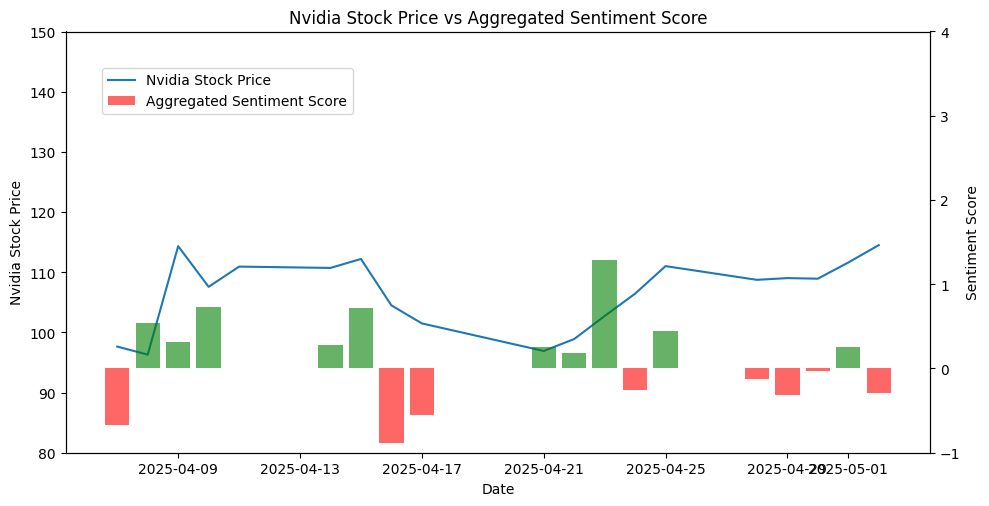

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel('Nvidia Stock Price')
ax1.plot(combined_data['Date'], combined_data['Close'], label='Nvidia Stock Price')
ax1.set_ylim(80, 150)

ax2 = ax1.twinx()
ax2.set_ylabel('Sentiment Score')

colors = ['green' if val >= 0 else 'red' for val in combined_data['sentiment_score']]
ax2.bar(combined_data['Date'], combined_data['sentiment_score'], label='Aggregated Sentiment Score', color=colors, alpha=0.6)
ax2.set_ylim(-1, 4)

fig.tight_layout()
plt.title('Nvidia Stock Price vs Aggregated Sentiment Score')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

This project showed that combining textual data with numerical financial data can uncover valuable signals in market behavior. While sentiment scores alone can’t predict prices, they can enhance our understanding of investor psychology and provide early warnings of shifts in perception.